# Import libraries

In [1]:
import gc
# gc.collect()

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

from my_toolbox import create_model as cm
from my_toolbox import data_describe as dd
from my_toolbox import stepwise

# Read file

In [2]:
path = '../data/'
data_name = ["df_train", 'df_test', 'sample_submission']

df_train_all = pd.read_csv("{}{}.csv".format(path,data_name[0]), encoding='utf8')
print(df_train_all.shape)

df_test = pd.read_csv("{}{}.csv".format(path,data_name[1]), encoding='utf8')
print(df_test.shape)

df_submit = pd.read_csv("{}{}.csv".format(path,data_name[2]), encoding='utf8')
print(df_submit.shape)

# -----------data info
data_describe1 =dd.data_describe(df_train_all);
data_describe2 = dd.data_describe(df_test);
data_describe1[data_describe1.is_null==True].sum()

(1460, 196)
(1459, 195)
(1459, 2)


duplicate       0.0
is_null         0.0
null_number     0.0
null_rate(%)    0.0
dtype: float64

In [3]:
print(df_train_all.columns)
print(df_test.columns)

Index(['RoofMatl_WdShake', 'Neighborhood_Blmngtn', 'RoofMatl_WdShngl',
       'Neighborhood_NridgHt', 'PCA_7', 'Neighborhood_CollgCr',
       'Condition1_PosN', 'Condition2_Artery', 'GarageFinish',
       'Exterior2nd_CBlock',
       ...
       'Foundation_Stone', 'SaleType_New', 'LowQualFinSF', 'MSSubClass_80',
       'MoSold_12', 'Neighborhood_NAmes', 'SaleType_Con', 'BldgType_1Fam',
       'Neighborhood_Crawfor', 'SalePrice'],
      dtype='object', length=196)
Index(['RoofMatl_WdShake', 'Neighborhood_Blmngtn', 'RoofMatl_WdShngl',
       'Neighborhood_NridgHt', 'PCA_7', 'Neighborhood_CollgCr',
       'Condition1_PosN', 'Condition2_Artery', 'GarageFinish',
       'Exterior2nd_CBlock',
       ...
       'Exterior2nd_CmentBd', 'Foundation_Stone', 'SaleType_New',
       'LowQualFinSF', 'MSSubClass_80', 'MoSold_12', 'Neighborhood_NAmes',
       'SaleType_Con', 'BldgType_1Fam', 'Neighborhood_Crawfor'],
      dtype='object', length=195)


# Feature Select by Lasso

In [4]:
from sklearn.linear_model import LassoCV

x = df_train_all.iloc[:, :-1].values
y = df_train_all.iloc[:, -1]

# lassocv = LassoCV(alphas=[i for i in range(1, 1000)], max_iter=50000, normalize=False)
lassocv = LassoCV(max_iter=500000, normalize=True)
lassocv.fit(x, y)

mask = (lassocv.coef_ != 0)
print(mask.sum())
x = x[:, mask]
print(x.shape)
print(lassocv.alpha_)

df_test = df_test.loc[:, mask]
print(type(df_test))

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


65
(1460, 65)
0.00043403018412200233
<class 'pandas.core.frame.DataFrame'>


## Separate Train data's x and y

In [5]:
df_train_x = x
df_train_y = y
# df_train_x = df_train_all.iloc[:, :-1].values
# df_train_y = df_train_all.iloc[:, -1].values
print(df_train_x.shape)
print(df_train_y.shape)

(1460, 65)
(1460,)


# Model

In [6]:
from sklearn.model_selection import train_test_split

# df_train_x = df_train_x.values
# df_train_y = df_train_y.values
train_x, val_x, train_y, val_y = train_test_split(df_train_x, df_train_y, test_size=0.2)

In [7]:
my_model = cm.modeling(df_train_x, df_train_y)

train_x (1168, 65)
train_y (1168,)
val_x (292, 65)
val_y (292,)


### Linear regression

### Lasso

### Ridge

### Elastic Net

### Random Forest

### XGBoost

[21:01:21] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


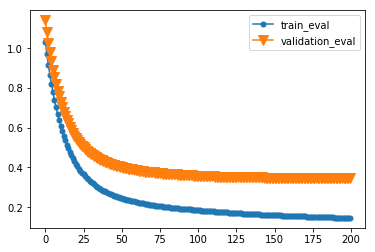

RMSE: [0]	eval-rmse:0.345556
r-square for validation data is 0.9033493108478245
r-square for train data is 0.9773483501885827
cost time: 0.5203590393066406


In [8]:
#給予模型參數，告知演算法該如何訓練模型
param = {
        'booster': 'gbtree',
        'objective':'reg:linear', # 做線性回歸
        'tree_method':'hist',
        'gamma':0.1,    # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
        'silent':1,     # 设置成1则没有运行信息输出，最好是设置为0.
        'subsample': 0.8,  # 随机采样训练样本
        'max_depth':5,     # 构建树的深度，越大越容易过拟合
        'nthread': 8,      # cpu 线程数
        'lambda': 15,       # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
        'eta': 0.08,                  # 如同学习率
        'seed': 10000,
        'min_child_weight': 3
        }
num_round = 200


xgb_model = my_model.xgb_modeling(param, num_round)

In [9]:
# output result to csv
import xgboost as xgb

test_x = df_test.values

xgb_test_x = xgb.DMatrix(test_x)

test_y = xgb_model.predict(xgb_test_x)


df_result = pd.DataFrame(df_submit['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('../submit/xgb_result.csv', index=False)

---